In [4]:
%matplotlib inline
import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
# #sys.path.append('/mnt/lustre/share/zhanxiaohang/proj/cocoapi/PythonAPI')
# sys.path.append('/home/xhzhan/deps/cocoapi/PythonAPI')
import pycocotools.mask as maskUtils
import cv2
import yaml
import numpy as np
import cvbase as cvb
from PIL import Image
from skimage import measure
from scipy import ndimage
import bezier
from opencv_mat import global_matting, guided_filter

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import torch.nn as nn
import torchvision.transforms as transforms

sys.path.append('..')
import models
import utils
import inference as infer
import pdb
from datasets import SASDataset, reader
data_root = '/home/xhzhan/data'
# data_root = '../data'

font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

pydensecrf not installed


In [5]:
class ArgObj(object):
    def __init__(self):
        pass

class Tester(object):
    
    def __init__(self, config_file, load_iter):
        args = ArgObj()
        with open(config_file, 'r') as f:
            config = yaml.load(f)
        for k, v in config.items():
            setattr(args, k, v)
        
        if not hasattr(args, 'exp_path'):
            args.exp_path = os.path.dirname(config_file)
        
        self.model = models.__dict__[args.model['algo']](args.model, dist_model=False)
        self.model.load_state("{}/checkpoints".format(args.exp_path), load_iter)
        
        self.model.switch_to('eval')
        self.use_rgb = args.model['use_rgb']
        
        self.args = args

class TesterContent(object):
    
    def __init__(self, config_file, load_iter):
        args = ArgObj()
        with open(config_file, 'r') as f:
            config = yaml.load(f)
        for k, v in config.items():
            setattr(args, k, v)
        
        if not hasattr(args, 'exp_path'):
            args.exp_path = os.path.dirname(config_file)
        
        self.model = models.__dict__[args.model['algo']](args.model, dist_model=False, demo=True)
        self.model.load_state("{}/checkpoints".format(args.exp_path), load_iter)
        
        self.model.switch_to('eval')
        self.img_transform = transforms.Compose([
            transforms.Normalize(args.data['data_mean'], args.data['data_std'])])
        
        self.args = args

    def inference(self, rgb, modal, category, amodal, dilate=0):
        rgb = self.img_transform(torch.from_numpy(
            rgb.astype(np.float32).transpose((2, 0, 1)) / 255.)).unsqueeze(0)
        invisible_mask = ((amodal == 1) & (modal == 0)).astype(np.uint8)
        if dilate > 0:
            invisible_mask = cv2.dilate(invisible_mask, np.ones((dilate,dilate),np.uint8), iterations=1)
        visible_mask = (1 - invisible_mask).astype(np.float32)[np.newaxis,np.newaxis,:,:]
        visible_mask = torch.from_numpy(visible_mask) # 11HW
        modal = torch.from_numpy(modal.astype(np.float32)).unsqueeze(0).unsqueeze(0) * float(category) # 11HW
        rgb_erased = rgb * visible_mask.repeat(1,3,1,1)
        visible_mask4 = visible_mask.repeat(1, 4, 1, 1)
        with torch.no_grad():
            output, _ = self.model.model(torch.cat([rgb_erased.cuda(), modal.cuda()], dim=1), visible_mask4.cuda())
            output_comp = visible_mask * rgb + (1 - visible_mask) * output.detach().cpu()
        result = torch.clamp(utils.unormalize(
            output_comp, self.args.data['data_mean'], self.args.data['data_std']) * 255, 0, 255)
        rgb_erased = torch.clamp(utils.unormalize(
            rgb_erased, self.args.data['data_mean'], self.args.data['data_std']) * 255, 0, 255)

        return result.numpy().astype(np.uint8).squeeze().transpose((1,2,0)), \
               rgb_erased.numpy().astype(np.uint8).squeeze().transpose((1,2,0)), \
               visible_mask.numpy().squeeze()
        
def show(inputs, scale=1.0, cols=-1):
    num = len(inputs)
    if cols == -1:
        cols = num
    rows = int(np.ceil(num / float(cols)))
    plt.figure(figsize=(12*scale, 12*scale/cols*rows))
    for i in range(num):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(inputs[i])
        plt.axis('off')
    plt.show()
    
def combine(inst, eraser):
    inst = inst.copy().astype(np.float32)
    inst[eraser == 1] = 0.5
    return inst

def colormap(mask):
    show = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for c in range(3):
        show[:,:,c][mask == 1] = 255
        show[:,:,c][mask == 0.5] = 128
    return show
    
def draw_graph(matrix, ind=None, pos=None):
    edges = np.where(matrix == 1)
    if ind is not None:
        from_idx = []
        to_idx = []
        for i in range(len(edges[0])):
            if edges[0][i] in ind and edges[1][i] in ind:
                from_idx.append(edges[0][i])
                to_idx.append(edges[1][i])
    else:
        from_idx = edges[0].tolist()
        to_idx = edges[1].tolist()
        
    from_node = [str(i+1) for i in from_idx]
    to_node = [str(i+1) for i in to_idx]

    G = nx.DiGraph()
    G.add_edges_from(list(zip(from_node, to_node)))
    if pos is None:
#         pos = nx.kamada_kawai_layout(G)
        pos = nx.spring_layout(G,k=0.5,iterations=20)
#         pos = nx.planar_layout(G)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos, font_color='w')
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, width=2)
    return pos

def get_square_bbox(h, w):
    if h > w:
        return [-(h-w) // 2, 0, h, h]
    else:
        return [0, -(w-h) // 2, w, w]

def expand_bbox(bboxes, enlarge_ratio):
    new_bboxes = []
    for bbox in bboxes:
        centerx = bbox[0] + bbox[2] / 2.
        centery = bbox[1] + bbox[3] / 2.
        size = max([np.sqrt(bbox[2] * bbox[3] * enlarge_ratio), bbox[2] * 1.1, bbox[3] * 1.1])
        new_bbox = [int(centerx - size / 2.), int(centery - size / 2.), int(size), int(size)]
        new_bboxes.append(new_bbox)
    return np.array(new_bboxes)

def gettrimap(mask, k):
    """
    Compute matting trimap from given mask.
    :param mask: binary ground truth mask
    :param k: number of extended pixels
    :return: matting trimap. 255 for groundtruth foreground, 127 for uncertain area, 0 for ground truth background
    """
    #np.set_printoptions(threshold=np.nan)
    kernel = np.ones((2 * k + 1, 2 * k + 1), dtype=np.int32)
    trimap = ndimage.convolve(mask, kernel, mode='constant')

    trimap = (trimap > 0) * 127
    trimap[mask > 0] = 255

    if trimap.max() != 255 or trimap.min() != 0:
        raise TrimapError('matting trimap failed.')
    return trimap.astype(np.uint8)

def matting(rgb, mask):
    trimapi = gettrimap(mask, 5)
    alphamapi = global_matting(rgb, trimapi)
    alphamapi = guided_filter(rgb, trimapi, alphamapi, 10, 1e-5)
    return alphamapi

# background inpainint
def bkg_inpaint(image, modal, ex_ind, dilate, bbox=None):
    modal_bkg = (sum([modal[e] for e in ex_ind]) == 0).astype(np.uint8)
    amodal_bkg = np.ones(image.shape[:2], dtype=np.uint8)
    need_recover = False
    if bbox is None:
        need_recover = True
        bbox = get_square_bbox(*image.shape[:2])
    rgb = cv2.resize(
        utils.crop_padding(image, bbox, pad_value=(0,0,0)), (256, 256), interpolation=cv2.INTER_CUBIC)
    modal_patch = cv2.resize(
        utils.crop_padding(modal_bkg, bbox, pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
#     modal_patch = (matting(rgb, modal_patch) == 255).astype(np.uint8)
    amodal_patch = cv2.resize(
        utils.crop_padding(amodal_bkg, bbox, pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
    ret, rgb_erased, vsb_mask = tester_content.inference(
        rgb, modal_patch, 1, amodal_patch, dilate=dilate)
    if need_recover:
        ret = recover_image_patch(ret, bbox, image.shape[0], image.shape[1])
    return ret, vsb_mask

def recover_image_patch(patch, bbox, h, w):
    size = bbox[2]
    patch = cv2.resize(patch, (size, size), interpolation=cv2.INTER_CUBIC)
    woff, hoff = bbox[0], bbox[1]
    newbbox = [-woff, -hoff, w, h]
    return utils.crop_padding(patch, newbbox, pad_value=(255,255,255))

def inpaint(image, bboxes, inmodal_patches, amodal_patches_pred, category, idx, dilate, debug=False):
    rgb = cv2.resize(
        utils.crop_padding(image, bboxes[idx], pad_value=(0,0,0)), (256, 256), interpolation=cv2.INTER_CUBIC)
    #modal_patch = cv2.resize(
    #    utils.crop_padding(modal[idx], bboxes[idx], pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
    modal_patch = inmodal_patches[idx]
    #amodal_patch = cv2.resize(
    #    utils.crop_padding(amodal_pred[idx], bboxes[idx], pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
#     modal_patch = (matting(rgb, modal_patch) == 255).astype(np.uint8)
    amodal_patch = amodal_patches_pred[idx]
    ret, rgb_erased, vsb_mask = tester_content.inference(
        rgb, modal_patch, category[idx].item(), amodal_patch, dilate=dilate)
    ret = recover_image_patch(ret, bboxes[idx], image.shape[0], image.shape[1])
#     mask = infer.recover_mask(amodal_patch, bboxes[idx], image.shape[0], image.shape[1], cv2.INTER_LINEAR)
#     mask = np.tile(mask[:,:,np.newaxis], (1,1,3))
#     ret[mask == 0] = 255
#     if debug:
#         show([rgb_erased, modal_patch, vsb_mask, ret])
    return ret

def polygon_drawing(masks, selidx, color_source, bbox):
    polygons = []
    colors = []
    if bbox is not None:
        l,u,r,b = bbox
        masks = masks[:, u:b, l:r]
    for i,am in enumerate(masks[selidx,...]):
        pts_list = reader.mask_to_polygon(am)
        for pts in pts_list:
            pts = np.array(pts).reshape(-1, 2)
            polygons.append(Polygon(pts))
            colors.append(color_source[i])
    pface = PatchCollection(polygons, facecolor=colors, linewidths=0, alpha=0.4)
    pedge = PatchCollection(polygons, facecolor='none', edgecolors=colors, linewidths=2)
    return pface, pedge

def image_resize(image, short_size=None, long_size=None):
    '''
    Resize image by specify short_size or long_size
    img: numpy.ndarray
    '''
    assert (short_size is None) ^ (long_size is None)
    h, w = image.shape[:2]
    if short_size is not None:
        if w < h:
            neww = short_size
            newh = int(short_size / float(w) * h)
        else:
            neww = int(short_size / float(h) * w)
            newh = short_size
    else:
        if w < h:
            neww = int(long_size / float(h) * w)
            newh = long_size
        else:
            neww = long_size
            newh = int(long_size / float(w) * h)
    image = cv2.resize(image, (neww, newh), interpolation=cv2.INTER_LINEAR)
    return image


In [6]:
phase = 'val'
img_root = '{}/SAS/sas_val'.format(data_root)
annot_fn = '{}/SAS/annotations/COCO_amodal_val2014.json'.format(data_root)
data_reader = SASDataset(annot_fn)

In [7]:
exp = '../experiments/SAS/partial_unet2_in5_front0.8'

config_file = exp + '/config.yaml'
load_iter = 56000

tester = Tester(config_file, load_iter)

/home/xhzhan/anaconda3/envs/pytorch041/lib/python3.7/site-packages/ipykernel_launcher.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  # Remove the CWD from sys.path while we load stuff.


=> loading checkpoint '../experiments/SAS/partial_unet2_in5_front0.8/checkpoints/ckpt_iter_56000.pth.tar'


In [8]:
exp = '../experiments/SAS/content_pconvcgan_modalmask_pretrained_lr-4'

config_file = exp + '/config.yaml'
load_iter = 450000

tester_content = TesterContent(config_file, load_iter)

/home/xhzhan/anaconda3/envs/pytorch041/lib/python3.7/site-packages/ipykernel_launcher.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


=> loading checkpoint '../experiments/SAS/content_pconvcgan_modalmask_pretrained_lr-4/checkpoints/ckpt_iter_450000.pth.tar'


In [14]:
tmp_list = []

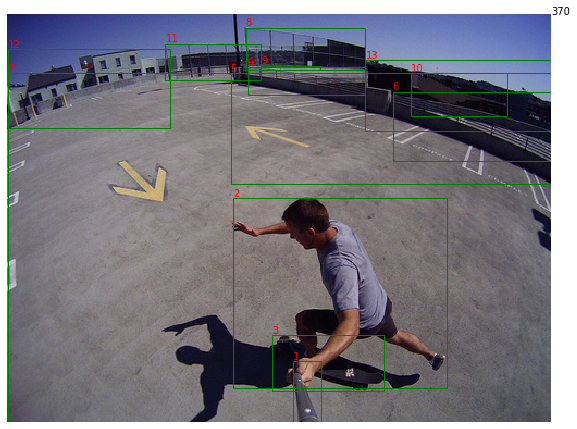

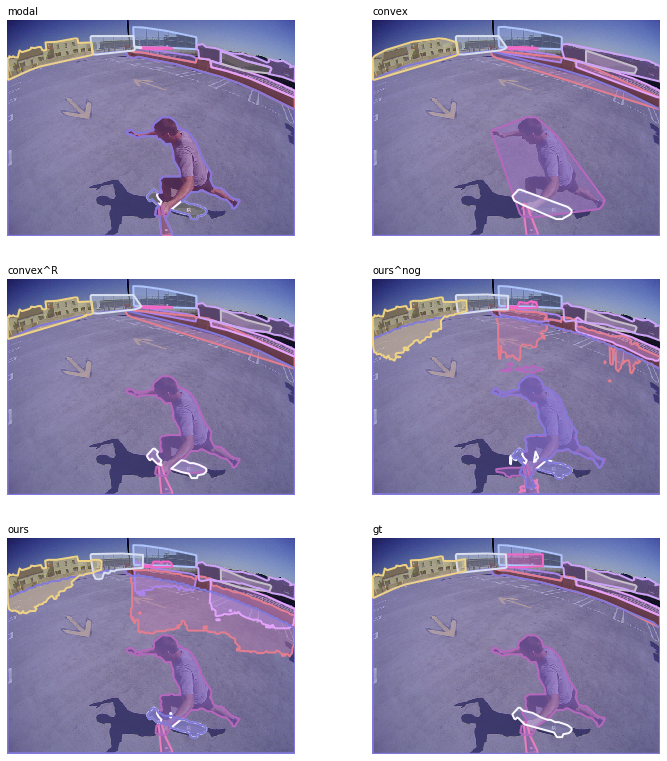

In [48]:
# img_idx = 86 # good example 10,11,12,13,14
# img_idx = 103 # good 9
# img_idx = 106 # good 31,32
# img_idx = 142 # good 11
# img_idx = 650 # complicated
# img_idx = 703 # intro
# img_idx = 408 # 1,6,7,5,8
# img_idx = 482 # 0.5
img_idx = np.random.choice(data_reader.get_image_length())
# img_idx = 29 # 1,2,3,6
# img_idx = 11
# train
# img_idx = 324
# img_idx = 37
# remove = np.array([1,2,3,6])-1
tmp_list.append(img_idx)
remove = []

modal, category, ori_bboxes, amodal_gt, image_fn = data_reader.get_image_instances(img_idx, with_gt=True)
#img_path = os.path.join(img_root, image_fn)
img = Image.open("{}/{:04d}.jpg".format(img_root, img_idx))
image = np.array(img)
height, width = img.height, img.width
plt.figure(figsize=(10, 10./width*height))
plt.imshow(img)
plt.axis('off')
plt.text(img.width, 0, str(img_idx))
ax = plt.gca()
for i, bbox in enumerate(ori_bboxes):
    rect = patches.Rectangle(bbox[:2], bbox[2], bbox[3], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1]-2, str(i+1), color='r')
plt.show()
bboxes = expand_bbox(ori_bboxes, enlarge_ratio=3.)
#gt_order_matrix = data_reader.get_gt_ordering(img_idx)
gt_order_matrix = infer.infer_gt_order(modal, amodal_gt)

# convex
order_matrix_cvx = infer.infer_order_hull(modal)
amodal_pred_cvx = np.array(infer.infer_amodal_hull(modal, bboxes, None, order_grounded=False))
amodal_pred_cvxr = np.array(infer.infer_amodal_hull(modal, bboxes, order_matrix_cvx))

# ours
if True:
    order_matrix, pair_ind, modal_paired, eraser_paired, amodal_paired = infer.infer_order2(
    tester.model, image, modal, category, bboxes,
    use_rgb=tester.use_rgb, th=0.1, dilate_kernel=0,
    input_size=256, min_input_size=16, interp='nearest', debug_info=True)
else:
    order_matrix = gt_order_matrix
interp = 'linear'
inmodal_patches, occluder_patches, amodal_patches_pred = infer.infer_amodal(
    tester.model, image, modal, category, bboxes, order_matrix,
    use_rgb=tester.use_rgb, th=0.3, dilate_kernel=0,
    input_size=256, min_input_size=16, interp=interp, debug_info=True)
amodal_pred = infer.patch_to_fullimage(
    amodal_patches_pred, bboxes, image.shape[0], image.shape[1], interp=interp)
#amodal_pred = amodal_gt

amodal_patches_pred_nog = infer.infer_amodal(
    tester.model, image, modal, category, bboxes, order_matrix,
    use_rgb=tester.use_rgb, th=0.2, dilate_kernel=0,
    input_size=256, min_input_size=16, interp=interp, order_grounded=False, debug_info=False)
amodal_pred_nog = infer.patch_to_fullimage(
    amodal_patches_pred_nog, bboxes, image.shape[0], image.shape[1], interp=interp)

if img_idx == 408:
    amodal_pred[3,304:312, 131:134] = 0

allpair_true, allpair, occpair_true, occpair, show_err = infer.eval_order(order_matrix, gt_order_matrix)
acc_allpair = allpair_true / allpair
acc_occpair = occpair_true / occpair

# show amodal
selidx = np.arange(amodal_pred.shape[0])
selidx = np.array([i for i in selidx if i not in remove])
plt.figure(figsize=(12, 12./width*height * 3 / 2))
toshow = [modal, amodal_pred_cvx, amodal_pred_cvxr, amodal_pred_nog, amodal_pred, amodal_gt]
title = ['modal', 'convex', 'convex^R', 'ours^nog', 'ours', 'gt']
highlight = [np.array([1,1,0.4]), np.array([0.4,1,1]),np.array([0.4,1,0.4])]
colors = [(np.random.random((1, 3)) * 0.6 + 0.4).tolist()[0] for i in range(len(selidx))]
# colors[16] = highlight[0]
# colors[17] = highlight[2]
# colors[18] = highlight[2]
for i in range(6):
    plt.subplot(3, 2, i + 1)
    ax = plt.gca()
    plt.imshow(image)
    plt.axis('off')
    plt.text(0, -10, title[i])
    pface, pedge = polygon_drawing(toshow[i], selidx, colors, None)
    ax.add_collection(pface)
    ax.add_collection(pedge)
# plt.savefig('outputs/amodal_display/sas_{}.jpg'.format(img_idx), dpi=72)
# cv2.imwrite("outputs/amodal_display/sas_{}_img.jpg".format(img_idx),
#             image_resize(image[:,:,::-1], long_size=480))
plt.show()

In [13]:
selidx

array([1, 2, 3])

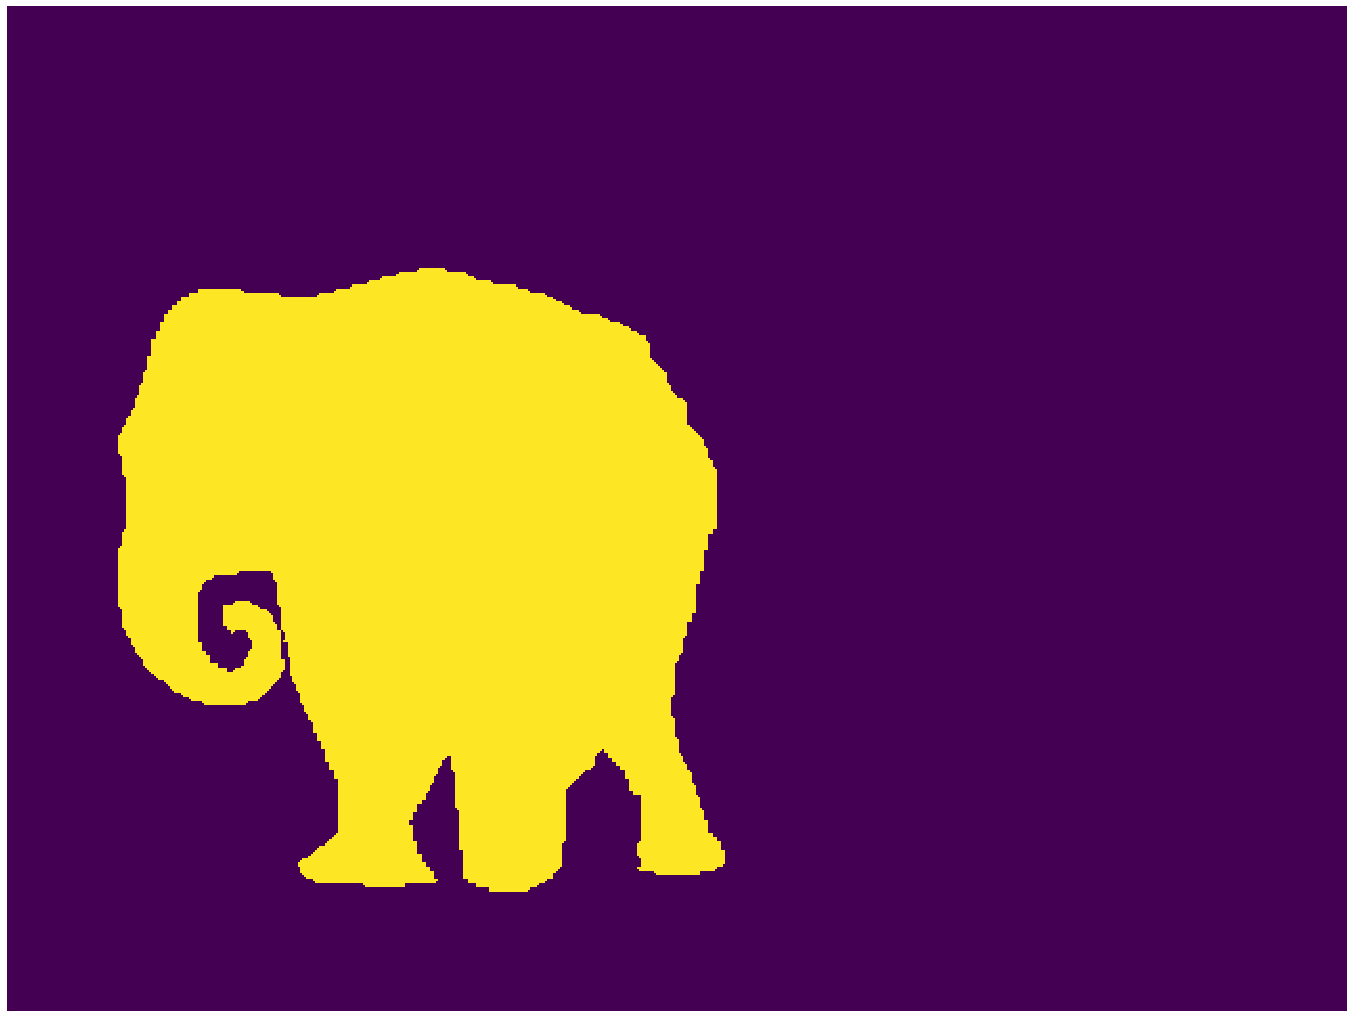

In [101]:
#show([amodal_pred[3], amodal_gt[3]], scale=2)
msk = amodal_pred[3].copy().astype(np.float32)
msk[304:312, 131:134] = 0
show([msk], scale=2)

In [94]:
msk.shape

(480, 640)

/home/xhzhan/anaconda3/envs/pytorch041/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/xhzhan/anaconda3/envs/pytorch041/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


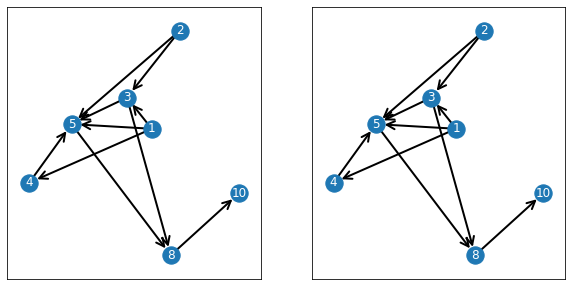

1.0
1.0
[]


In [5]:
selind = np.array([1,2,3,4,5,6,8,9,10]) - 1
# selind = None
plt.figure(figsize=(10,5))
plt.subplot(121)
pos = draw_graph(gt_order_matrix, ind=selind)
plt.subplot(122)
draw_graph(order_matrix, pos=pos,ind=selind)
plt.show()
print(acc_allpair)
print(acc_occpair)
print(show_err)

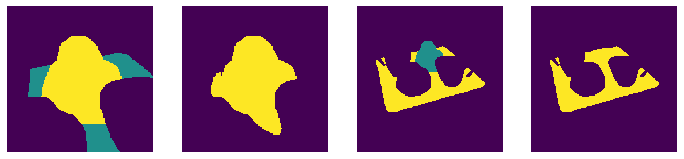

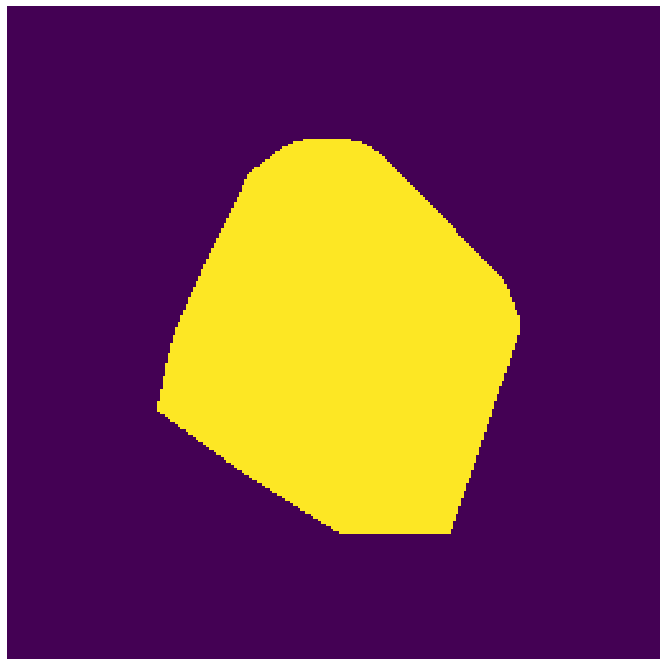

In [23]:
# amodal debug
idx1, idx2 = 3,5
idx1, idx2 = idx1-1, idx2-1

indidx1 = np.where((pair_ind == np.array([idx1,idx2])).all(axis=1))[0].item()
inmodal1 = modal_paired[indidx1]
eraser1 = eraser_paired[indidx1]
amodal1 = amodal_paired[indidx1]
comb1 = combine(inmodal1, eraser1)

indidx2 = np.where((pair_ind == np.array([idx2,idx1])).all(axis=1))[0].item()
inmodal2 = modal_paired[indidx2]
eraser2 = eraser_paired[indidx2]
amodal2 = amodal_paired[indidx2]
comb2 = combine(inmodal2, eraser2)

show([comb1, amodal1, comb2, amodal2])


# bezier

# def get_neighbor(pts, p):
#     dist = np.sqrt(np.sum((pts - np.tile(p[np.newaxis,:], (pts.shape[0], 1)))**2, axis=1))
#     ind = np.where((dist < 1.5) & (dist >= 1))[0]
#     return pts[ind,:]

# def find_terminal(pts):
#     terminals = []
#     for p in pts:
#         neigh = get_neighbor(pts, p)
#         if neigh.shape[0] in [0, 1]:
#             terminals.append(p)
#         elif neigh.shape[0] == 2:
#             n1 = neigh[0,:]
#             n2 = neigh[1,:]
#             if np.abs(n1[0] - n2[0]) + np.abs(n1[1] - n2[1]) == 1:
#                 #pdb.set_trace()
#                 terminals.append(p)
#     return terminals

# kernel = np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]], dtype=np.uint8)
# # kernel = np.ones((3,3), dtype=np.uint8)
# inter = cv2.dilate(eraser1, kernel, iterations=1) * inmodal1
# pos = np.where(inter)
# pts = np.concatenate((pos[1][:,np.newaxis], pos[0][:,np.newaxis]), axis=1)
# terminal = find_terminal(pts)
# inter = inter.astype(np.float32)
# for t in terminal:
#     inter[t[1], t[0]] = 0.5
# show([inmodal1, eraser1, inter])
# show([inter])
# from skimage.morphology import convex_hull
# hull = convex_hull.convex_hull_image(inmodal1)
# show([hull])

In [26]:
hull.shape

(256, 256)

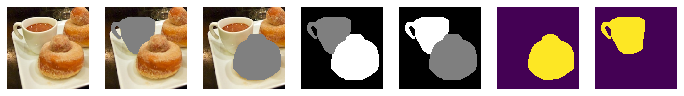

True

In [33]:
# dual comp
# eraser1 = cv2.dilate(eraser1, np.ones((3,3), dtype=np.uint8), iterations=1)
idx1 = 0
idx2 = 3
bbox = utils.combine_bbox(ori_bboxes[(idx1, idx2),:])
centerx = bbox[0] + bbox[2] / 2.
centery = bbox[1] + bbox[3] / 2.
size = max([np.sqrt(bbox[2] * bbox[3] * 1.5), bbox[2] * 1.1, bbox[3] * 1.1])
bbox = [int(centerx - size / 2.), int(centery - size / 2.), int(size), int(size)]
dual_image = cv2.resize(utils.crop_padding(image, bbox, pad_value=(0,0,0)), (256, 256), cv2.INTER_CUBIC)
modal1 = cv2.dilate(
    infer.resize_mask(utils.crop_padding(modal[idx1], bbox, pad_value=(0,)), 256, 'linear'),
    np.ones((5,5), dtype=np.uint8), iterations=1)
modal2 = infer.resize_mask(utils.crop_padding(modal[idx2], bbox, pad_value=(0,)), 256, 'linear')
amodal1 = infer.resize_mask(utils.crop_padding(amodal_pred[idx1], bbox, pad_value=(0,)), 256, 'linear').astype(np.uint8) * 255
amodal2 = infer.resize_mask(utils.crop_padding(amodal_pred[idx2], bbox, pad_value=(0,)), 256, 'linear').astype(np.uint8) * 255

comb1 = (np.tile(combine(modal1, modal2)[:,:,np.newaxis], (1,1,3)) * 255).astype(np.uint8)
comb2 = (np.tile(combine(modal2, modal1)[:,:,np.newaxis], (1,1,3)) * 255).astype(np.uint8)
rgbe1 = dual_image.copy()
rgbe1[modal2 == 1, :] = 128
rgbe2 = dual_image.copy()
rgbe2[modal1 == 1, :] = 128

show([dual_image, rgbe1, rgbe2, comb1, comb2, amodal1, amodal2])
cv2.imwrite("outputs/dualcomp/image.png", dual_image[:,:,::-1])
cv2.imwrite("outputs/dualcomp/rgbe1.png", rgbe1[:,:,::-1])
cv2.imwrite("outputs/dualcomp/rgbe2.png", rgbe2[:,:,::-1])
cv2.imwrite("outputs/dualcomp/comb1.png", comb1)
cv2.imwrite("outputs/dualcomp/comb2.png", comb2)
cv2.imwrite("outputs/dualcomp/amodal1.png", amodal1)
cv2.imwrite("outputs/dualcomp/amodal2.png", amodal2)

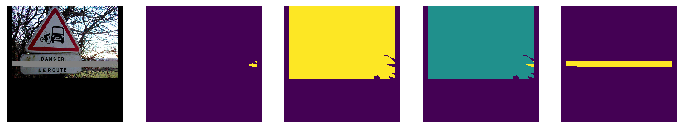

In [74]:
# fig: completion
idx = 4
idx = idx - 1
if False:
    show([image, inmodal[idx], amodal_pred[idx]])
else:
    #inmodal_show = cv2.resize(
    #    utils.crop_padding(modal[idx], bboxes[idx], pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
    inmodal_show = inmodal_patches[idx]
    eraser_show = occluder_patches[idx]
    eraser_show = cv2.dilate(eraser_show, np.ones((3,3), dtype=np.uint8), iterations=1)
    comb = combine(inmodal_show, eraser_show)
    rgb_show = cv2.resize(utils.crop_padding(image, bboxes[idx], pad_value=(0,0,0)), (256, 256), interpolation=cv2.INTER_CUBIC)
    res = infer.resize_mask(
        utils.crop_padding(amodal_pred[idx], bboxes[idx], pad_value=(0,)), 256, 'linear')
    intersection = np.tile(((res==1) & (eraser_show == 1))[:,:,np.newaxis], (1,1,3))
    rgb_show[intersection] = 128
    show([rgb_show,
          inmodal_show,
          eraser_show,
          comb,
          res])

rgbo = cv2.resize((utils.crop_padding(image[:,:,::-1], bboxes[idx], pad_value=(0,0,0))), (256, 256), interpolation=cv2.INTER_CUBIC)
rgb = rgbo.copy()
rgb[np.tile(eraser_show[:,:,np.newaxis], (1,1,3))==1] = 128
rgb_combo = rgb_show[:,:,::-1]
# cv2.imwrite('outputs/completion/rgbo.png', rgbo)
# cv2.imwrite('outputs/completion/rgb.png', rgb)
# cv2.imwrite('outputs/completion/modal.png', (inmodal_show * 255).astype(np.uint8))
# cv2.imwrite('outputs/completion/eraser.png', (eraser_show * 255).astype(np.uint8))
# cv2.imwrite('outputs/completion/amodal_comp_comb.png', (comb * 255).astype(np.uint8))
# cv2.imwrite('outputs/completion/amodal_comp_res.png', (res * 255).astype(np.uint8))
# cv2.imwrite('outputs/completion/content_comp_combo.png', rgb_combo)

In [11]:
def gammaCorrection(img_original, gamma=1.0):
    ## [changing-contrast-brightness-gamma-correction]
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    res = cv2.LUT(img_original, lookUpTable)
    return res
def combine_two_rgb(rgb1, rgb2, mask2, dilate=3, sigma=1.):
    mask2 = cv2.dilate(
            mask2, np.ones((dilate, dilate),np.uint8), iterations=1)
#     mask2 = cv2.GaussianBlur(mask2.astype(np.float32), (5,5), sigmaX=sigma)
    ret = rgb1.copy().astype(np.float32)
    rgb2 = rgb2.astype(np.float32)
    ret = rgb1 * (1 - mask2) + rgb2 * mask2
#     for c in range(3):
#         ret[:,:,c][mask2 == 1] = rgb2[:,:,c][mask2 == 1]
    return ret.astype(np.uint8), mask2

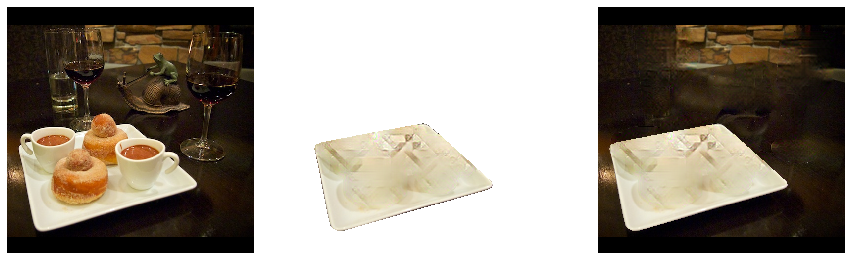

In [52]:
# decomposition
if True:
    inmodal_patches = [infer.resize_mask(
        utils.crop_padding(modal[i], bboxes[i], pad_value=(0,)), 256, 'linear') 
                           for i in range(bboxes.shape[0])]
    amodal_patches_pred = [infer.resize_mask(
        utils.crop_padding(amodal_gt[i], bboxes[i], pad_value=(0,)), 256, 'linear') 
                           for i in range(bboxes.shape[0])]
    
fg_idx = list(range(1,12))
fg_idx = [1,2,3,4,5,6,8,9,10]
fg_idx = [i-1 for i in fg_idx]
show_idx = 5
fg_dilate = 5
bg_dilate = 3
# brightness
# image_adj = gammaCorrection(image, gamma=0.9)
image_adj = image.copy()
# global box
involved_bbox = ori_bboxes[[i for i in fg_idx if i != 11], :]
global_bbox = [involved_bbox[:,0].min(), involved_bbox[:,1].min(), 
               (involved_bbox[:,0] + involved_bbox[:,2]).max(),
               (involved_bbox[:,1] + involved_bbox[:,3]).max()]
global_bbox[2] = global_bbox[2] - global_bbox[0]
global_bbox[3] = global_bbox[3] - global_bbox[1]
global_bbox = expand_bbox([global_bbox], 1.1)[0]
crop_image = utils.crop_padding(
    image_adj, global_bbox, pad_value=(0,0,0))

# decomp
rgb_decomps = []
mask_decomps = []
for i in fg_idx:
    ret = inpaint(image_adj, bboxes, inmodal_patches, amodal_patches_pred, category, i, fg_dilate, False)
    ret = utils.crop_padding(ret, global_bbox, pad_value=(255,255,255))
    mask = np.tile(utils.crop_padding(amodal_pred[i], global_bbox, pad_value=(0,))[:,:,np.newaxis], (1,1,3))
    ret[mask == 0] = 255
    rgb_decomps.append(ret)
    mask_decomps.append(mask)

# bkg inpaint
bkg, vsb_mask = bkg_inpaint(image_adj, modal, fg_idx, bg_dilate, global_bbox)
bkg = cv2.resize(bkg, tuple(global_bbox[2:]), interpolation=cv2.INTER_CUBIC)
vsb_mask = infer.resize_mask(vsb_mask, global_bbox[2], interp='linear')
for c in range(3):
    bkg[:,:,c][vsb_mask == 1] = crop_image[:,:,c][vsb_mask == 1]

# show
plt.figure(figsize=(15, 30./img.width*img.height))
ax = plt.subplot(131)
plt.imshow(crop_image)
plt.axis('off')
plt.subplot(132)
if show_idx == -1:
    plt.imshow(bkg)
else:
    this_obj = rgb_decomps[fg_idx.index(show_idx-1)]
    plt.imshow(this_obj)
plt.axis('off')
plt.subplot(133)
canvas = bkg.copy()
this_obj = rgb_decomps[fg_idx.index(show_idx-1)]
this_mask = mask_decomps[fg_idx.index(show_idx-1)]
canvas[this_mask == 1] = this_obj[this_mask == 1]
plt.imshow(canvas)
plt.axis('off')
plt.show()

# for i, (mask, obj) in enumerate(zip(mask_decomps, rgb_decomps)):
#     alpha = mask[:,:,:1] * 255
#     cv2.imwrite('outputs/isolated/obj_{}.png'.format(i), np.concatenate((obj[:,:,::-1], alpha), axis=2))
# cv2.imwrite('outputs/isolated/bkg.png', bkg[:,:,::-1])

# for i, (mask, obj) in enumerate(zip(mask_decomps, rgb_decomps)):
#     canvas = bkg.copy()
#     canvas[mask == 1] = obj[mask == 1]
#     alpha = mask[:,:,:1] * 255
#     cv2.imwrite('outputs/decomps/obj_{}.png'.format(i), np.concatenate((canvas[:,:,::-1], alpha), axis=2))
# cv2.imwrite('outputs/decomps/bkg.png', bkg[:,:,::-1])

In [22]:
bkg.shape

(499, 499, 3)

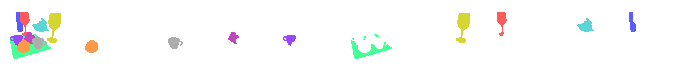

In [597]:
# show amodal
h = global_bbox[2]
canvas1 = np.ones((h, h, 3), dtype=np.uint8) * 255
ones = np.ones((h, h, 3), dtype=np.uint8) * 255
color_lut = np.array([[1,0.5,0.1], [0.6,0.6,0.6], [0.7,0.1,0.7], [0.5,0.1,1], [0.1,1,0.5], [0.8,0.8,0],
                      [1,0.2,0.2], [0.2,0.8,0.8], [0.2,0.2,1]])

crop = True
amodal_colors = []
modal_colors = []
for i in fg_idx:
    inst1 = np.tile(utils.crop_padding(
        modal[i], global_bbox, pad_value=(0,)).astype(np.float32)[:,:,np.newaxis], (1,1,3))
    inst2 = np.tile(utils.crop_padding(
        amodal_gt[i], global_bbox, pad_value=(0,)).astype(np.float32)[:,:,np.newaxis], (1,1,3))
    color = color_lut[fg_idx.index(i),:]
    color_inst1 = (np.tile(color[np.newaxis, np.newaxis, :], (h, h, 1)) * inst1 * 255).astype(np.uint8)
    color_inst2 = (np.tile(color[np.newaxis, np.newaxis, :], (h, h, 1)) * inst2 * 255).astype(np.uint8)
    canvas1[inst1 == 1] = (ones[inst1 == 1] * 0.2 + color_inst1[inst1 == 1] * 0.8).astype(np.uint8)
    
    modal_color = color_inst1.copy()
    modal_color[inst1 == 0] = 255
    modal_color = (ones * 0.2 + modal_color * 0.8).astype(np.uint8)
    modal_colors.append(modal_color.astype(np.uint8))
    
    amodal_color = color_inst2.copy()
    amodal_color[inst2 == 0] = 255
    amodal_color = (ones * 0.2 + amodal_color * 0.8).astype(np.uint8)
    amodal_colors.append(amodal_color.astype(np.uint8))
    
#     cv2.imwrite('outputs/intro/modal_{:02d}.png'.format(fg_idx.index(i)), modal_color[:,:,::-1])
#     cv2.imwrite('outputs/intro/amodal_{:02d}.png'.format(fg_idx.index(i)), amodal_color[:,:,::-1])
show([canvas1] + modal_colors)

# cv2.imwrite('outputs/intro/modalseg.png', canvas1[:,:,::-1])
# cv2.imwrite('outputs/intro/amodalseg.png', canvas2[:,:,::-1])


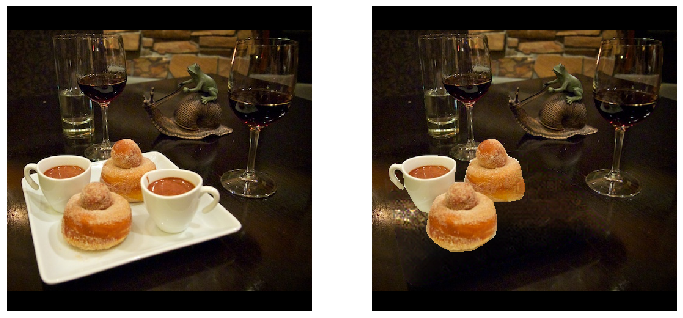

True

In [78]:
# recomposition
mode = 'delete'
if mode == 'random':
    order = np.random.permutation(fg_idx) + 1
    offset = [np.random.choice(range(-50, 50), (2,)) for i in fg_idx]
    scale = [np.random.uniform(0.5, 1.5) for i in fg_idx]
elif mode == 'swap':
    order = [10,9,8,6,5,4,2,1,3]
    offset = [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (-60,-10), (0,0), (40,20)]
    scale = np.ones((len(order),))
    scale[order.index(3)] = 1.1
    scale[order.index(2)] = 0.9
elif mode == 'move':
    order = [10,9,8,2,5,4,3,1,6]
    offset = [(0,0), (0,0), (0,0), (250,-40), (0,0), (0,0), (0,0), (0,0), (0,0)]
    scale = np.ones((len(order),))
    scale[order.index(2)] = 0.7 
elif mode == 'shift':
    order = [10,9,8,5,4,3,1,6,2]
    offset = [(0,0), (0,0), (0,0), (0,0), (0,0), (-20,4), (0,0), (0,0), (0,0)]
    scale = np.ones((len(order),))
elif mode == 'delete':
    order = [10,9,8,4,3,1,6]
    offset = [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0)]
    scale = np.ones((len(order),))
    
# bkg inpaint
bg_dilate = 3
bkg, vsb_mask = bkg_inpaint(image_adj, modal, fg_idx, bg_dilate, global_bbox)
bkg = cv2.resize(bkg, tuple(global_bbox[2:]), interpolation=cv2.INTER_CUBIC)
vsb_mask = infer.resize_mask(vsb_mask, global_bbox[2], interp='linear')
for c in range(3):
    bkg[:,:,c][vsb_mask == 1] = crop_image[:,:,c][vsb_mask == 1]

dilate_kernel = np.array([0,0,0,0,0,0,0,0,0])
canvas = bkg.copy()
h, w = canvas.shape[:2]
for i, ind in enumerate(order):
    ind -= 1
    bbox = (-offset[i][0], -offset[i][1], 1./scale[i] * w, 1./scale[i] * h)
    shift_rgb = cv2.resize(utils.crop_padding(rgb_decomps[fg_idx.index(ind)], bbox, pad_value=(0,0,0)),
                           (w, h), interpolation=cv2.INTER_CUBIC)
    shift_mask = cv2.resize(utils.crop_padding(mask_decomps[fg_idx.index(ind)], bbox, pad_value=(0,0,0)),
                            (w, h), interpolation=cv2.INTER_NEAREST)
    if dilate_kernel[i] > 0:
        shift_mask = 1 - cv2.dilate(
            1-shift_mask, np.ones((dilate_kernel[i], dilate_kernel[i]),np.uint8), iterations=1)
    canvas[shift_mask==1] = shift_rgb[shift_mask==1]
show([crop_image,canvas])
# show([bkg] + rgb_decomps, cols=2)
cv2.imwrite('outputs/recomp/{}.png'.format(mode), canvas[:,:,::-1])

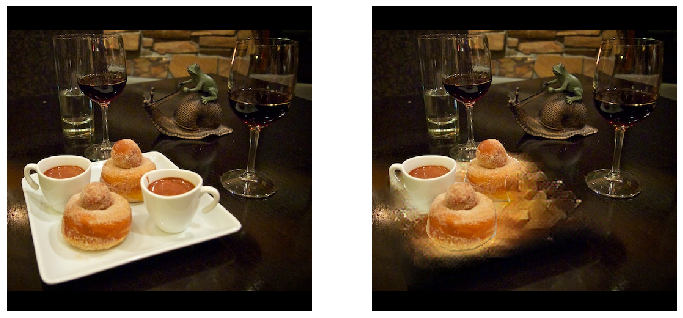

True

In [79]:
# recomposition inpainting
mode = 'delete'
foreground = [1,4]
original_order = [10,9,8,6,5,4,3,1,2]
if mode == 'random':
    offset = [np.random.choice(range(-50, 50), (2,)) for i in fg_idx]
    scale = [np.random.uniform(0.5, 1.5) for i in fg_idx]
elif mode == 'swap':
    offset = [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (40,20), (0,0),(-60,-10)]
    scale = np.ones((len(order),))
    scale[order.index(3)] = 1.1
    scale[order.index(2)] = 0.9
elif mode == 'move':
    offset = [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (250,-40)]
    scale = np.ones((len(order),))
#     scale[order.index(3)] = 1.1
    scale[order.index(2)] = 0.7
elif mode == 'shift':
    order = [10,9,8,6,5,4,1,2,3]
    offset = [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (-20,4)]
    scale = np.ones((len(order),))
elif mode == 'delete':
    order = [o for o in original_order if o-1 not in foreground]
    offset = [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (-20,4)]
    scale = np.ones((len(order),))
    
rgb_decomps_bsl = []
mask_decomps_bsl = []
for i in fg_idx:
    ret = utils.crop_padding(image_adj, global_bbox, pad_value=(255,255,255))
    mask = np.tile(utils.crop_padding(modal[i], global_bbox, pad_value=(0,))[:,:,np.newaxis], (1,1,3))
    ret[mask == 0] = 255
    rgb_decomps_bsl.append(ret)
    mask_decomps_bsl.append(mask)
    
# bkg inpaint
bg_dilate=5
bkg, vsb_mask = bkg_inpaint(image_adj, modal, foreground, bg_dilate, global_bbox)
bkg = cv2.resize(bkg, tuple(global_bbox[2:]), interpolation=cv2.INTER_CUBIC)
vsb_mask = infer.resize_mask(vsb_mask, global_bbox[2], interp='linear')
for c in range(3):
    bkg[:,:,c][vsb_mask == 1] = crop_image[:,:,c][vsb_mask == 1]

dilate_kernel = np.ones((len(fg_idx),), dtype=np.int) * 0
canvas = bkg.copy()
h, w = canvas.shape[:2]
for i, ind in enumerate(order):
    ind -= 1
    bbox = (-offset[i][0], -offset[i][1], 1./scale[i] * w, 1./scale[i] * h)
    shift_rgb = cv2.resize(utils.crop_padding(rgb_decomps_bsl[fg_idx.index(ind)], bbox, pad_value=(0,0,0)),
                           (w, h), interpolation=cv2.INTER_CUBIC)
    shift_mask = cv2.resize(utils.crop_padding(mask_decomps_bsl[fg_idx.index(ind)], bbox, pad_value=(0,0,0)),
                            (w, h), interpolation=cv2.INTER_NEAREST)
    if dilate_kernel[i] > 0:
        shift_mask = 1 - cv2.dilate(
            1-shift_mask, np.ones((dilate_kernel[i], dilate_kernel[i]),np.uint8), iterations=1)
    canvas[shift_mask==1] = shift_rgb[shift_mask==1]
# show(rgb_decomps_bsl)
show([crop_image,canvas])
cv2.imwrite('outputs/recomp/{}_inpaint.png'.format(mode), canvas[:,:,::-1])

In [37]:
np.random.uniform(0.5, 1.5, (2,))

array([0.76818138, 1.32273048])